In [ ]:
realwaste_dataset_path = "/Code/Datasets/realwaste-main/RealWaste"

In [9]:
import torch
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import time
import numpy as np
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import os
from glob import glob
import os
import PIL.Image
import math
from torchvision.transforms.functional import pil_to_tensor
from sklearn.metrics import recall_score, precision_score, accuracy_score
from tqdm.notebook import tqdm

In [2]:


labels = ["Cardboard", "Food Organics", "Glass", "Metal", "Miscellaneous Trash", "Paper", "Plastic", "Textile Trash", "Vegetation"]

def load_realwaste(path, sample_per_label = 300, training_percent = 0.8):
    if not os.path.isdir(path):
        raise Exception(f"{path} path does not exist")
    
    label_dict = {}

    for label in labels:
        label_dict[label] = []
        for file in glob(os.path.join(path, label, "*.jpg")):
            label_dict[label].append(PIL.Image.open(file).resize(size=(224, 224)))
    
    train_ds = []
    eval_ds = []
    train_count = math.floor(sample_per_label * training_percent)
    test_count = sample_per_label - train_count

    for label in labels:
        for i in range(train_count):
            if i < len(label_dict[label]):
                train_ds.append({"image": label_dict[label][i], "label": label, "y": labels.index(label)})
            else:
                print(f"Only {i} train samples for {label}")
                break

        for i in range(train_count, train_count + test_count):
            if i < len(label_dict[label]):
                eval_ds.append({"image": label_dict[label][i], "label": label, "y": labels.index(label)})
            else:
                print(f"Only {i} eval samples for {label}")
                break

    return pd.DataFrame(train_ds), pd.DataFrame(eval_ds)

train_df, eval_df = load_realwaste(realwaste_dataset_path)
display(train_df)
display(eval_df)

,image,label,y
0,<PIL.Image.Image image mode=RGB size=224x224 a...,Cardboard,0
1,<PIL.Image.Image image mode=RGB size=224x224 a...,Cardboard,0
2,<PIL.Image.Image image mode=RGB size=224x224 a...,Cardboard,0
3,<PIL.Image.Image image mode=RGB size=224x224 a...,Cardboard,0
4,<PIL.Image.Image image mode=RGB size=224x224 a...,Cardboard,0
...,...,...,...
2155,<PIL.Image.Image image mode=RGB size=224x224 a...,Vegetation,8
2156,<PIL.Image.Image image mode=RGB size=224x224 a...,Vegetation,8
2157,<PIL.Image.Image image mode=RGB size=224x224 a...,Vegetation,8
2158,<PIL.Image.Image image mode=RGB size=224x224 a...,Vegetation,8


,image,label,y
0,<PIL.Image.Image image mode=RGB size=224x224 a...,Cardboard,0
1,<PIL.Image.Image image mode=RGB size=224x224 a...,Cardboard,0
2,<PIL.Image.Image image mode=RGB size=224x224 a...,Cardboard,0
3,<PIL.Image.Image image mode=RGB size=224x224 a...,Cardboard,0
4,<PIL.Image.Image image mode=RGB size=224x224 a...,Cardboard,0
...,...,...,...
535,<PIL.Image.Image image mode=RGB size=224x224 a...,Vegetation,8
536,<PIL.Image.Image image mode=RGB size=224x224 a...,Vegetation,8
537,<PIL.Image.Image image mode=RGB size=224x224 a...,Vegetation,8
538,<PIL.Image.Image image mode=RGB size=224x224 a...,Vegetation,8


In [3]:
# Loading the .csv into the dataset

class RealWasteDataset(Dataset):
    def __init__(self, df):
        super().__init__()

        self.df = df

        self.y = df.iloc[:, 2]

        df = df.apply(lambda row: pil_to_tensor(row["image"]), axis=1)
        self.x = torch.stack(df.tolist(), dim=0)
        
        self.x = torch.tensor(self.x, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.long)

        self.x /= 255.0
        # self.x = F.interpolate(self.x, size=(224, 224), mode='bilinear', antialias=True)
        print(self.y.shape)
        print(self.x.shape)
        
    def shape(self):
        return self.x.shape

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

eval_ds = RealWasteDataset(eval_df)
train_ds = RealWasteDataset(train_df)

/tmp/ipykernel_400426/3618956446.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(self.x, dtype=torch.float32)


torch.Size([540])
torch.Size([540, 3, 224, 224])
torch.Size([2160])
torch.Size([2160, 3, 224, 224])


/tmp/ipykernel_400426/3618956446.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(self.x, dtype=torch.float32)


array([[<Axes: title={'center': 'y'}>]], dtype=object)

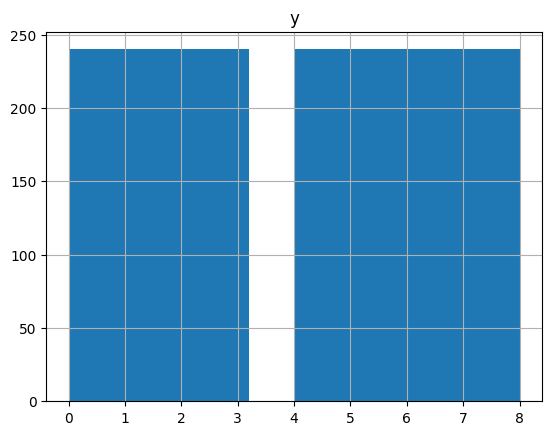

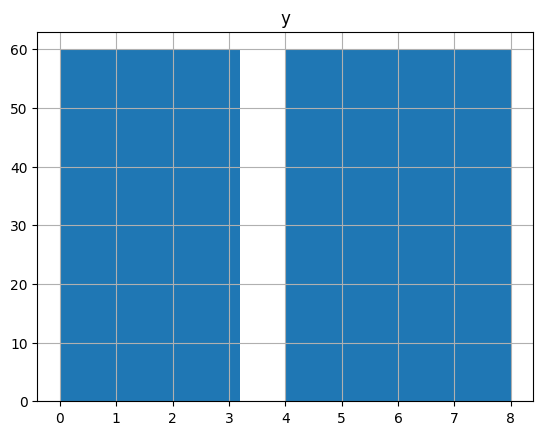

In [4]:
train_df.hist(column = 'y')
eval_df.hist(column = 'y')

In [4]:
train_loader = DataLoader(train_ds, batch_size=10, shuffle=True)
test_loader = DataLoader(eval_ds, batch_size=10, shuffle=False)

torch.Size([9])
torch.Size([9, 3, 224, 224])
torch.Size([9, 3, 224, 224])
    Cardboard      Food Organics      Glass      Metal      Miscellaneous Trash      Paper      Plastic      Textile Trash      Vegetation


/tmp/ipykernel_400426/3618956446.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(self.x, dtype=torch.float32)


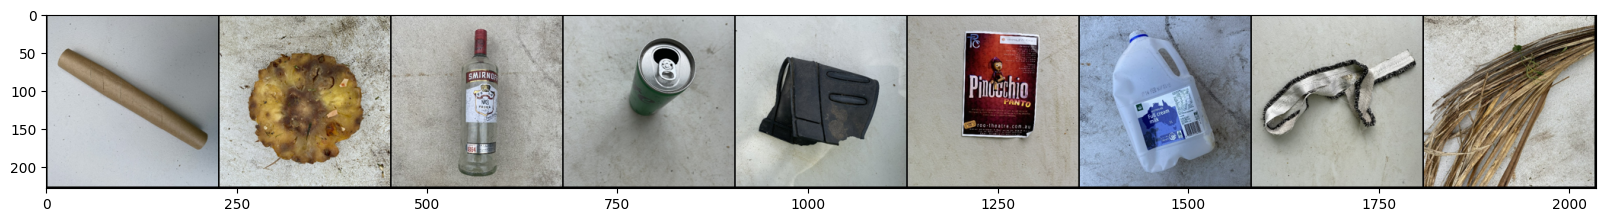

In [5]:
first_df = train_df.groupby('label', as_index=False).first()
first_dataset = RealWasteDataset(first_df)

images, l = first_dataset[:]
print(images.shape)

im = make_grid(images, nrow=len(first_df))
plt.figure(figsize=(20,8))
plt.imshow(np.transpose(im.numpy(),(1, 2, 0)))

labels_string = "      ".join(labels)
print("    " + labels_string)

In [6]:
# Defining the network architecture
BACKBONE_SIZE = "giant" # in ("small", "base", "large" or "giant")

backbone_archs = {
    "small": "vits14",
    "base": "vitb14",
    "large": "vitl14",
    "giant": "vitg14",
}

backbone_size = {
    "small": 384,
    "base": 768,
    "large": 1024,
    "giant": 1536 
}

class RealWasteModel(nn.Module):
    
    def __init__(self, dir=None):       
        super().__init__()
        self.backbone_arch = backbone_archs[BACKBONE_SIZE]
        self.backbone_name = f"dinov2_{self.backbone_arch}"

        self.fc1 = nn.Linear(in_features=backbone_size[BACKBONE_SIZE], out_features=len(labels))
        #self.fc2 = nn.Linear(in_features=512, out_features=128)
        #self.fc3 = nn.Linear(in_features=128, out_features=26)
        
        if dir != None:
            self.backbone_model = torch.hub.load(repo_or_dir='facebookresearch/dinov2', model=self.backbone_name, pretrained=False)
            self.load_state_dict(torch.load(dir))
        else:
            self.backbone_model = torch.hub.load(repo_or_dir='facebookresearch/dinov2', model=self.backbone_name, pretrained=True)
            
        for param in self.backbone_model.parameters():
            param.requires_grad = False

        self.backbone_model.eval()
        self.backbone_model.cuda()
        
    def forward(self, X):
        X = self.backbone_model(X)  
        #X = F.relu(self.fc1(X))
        #X = F.relu(self.fc2(X))
        
        return F.log_softmax(input=self.fc1(X), dim=1)  

In [8]:
# Training the model
epochs = 10

writer = SummaryWriter('RealWasteLog')

model = RealWasteModel()
model = model.cuda()

start_time = time.time()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
test_losses = []
accuracy_graph = []
precision_graph = []
recall_graph = []

for i in range(epochs):
    tst_corr = 0
    trn_corr = 0

    for b, (X_train, y_train) in tqdm(enumerate(train_loader)):
        b += 1
        X_train = X_train.cuda()
        y_train = y_train.cuda()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%28 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/{len(train_df)}]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
    
    writer.add_scalar("Loss/train", loss, i)     
    train_losses.append(loss.cpu().detach().numpy())
    

    # Test model per epoch
    model.eval()
    y_true_label = []
    predictions = []
    
    with torch.no_grad():
        for b, (X_test, y_test) in tqdm(enumerate(test_loader)):
            X_test = X_test.cuda()
            y_test = y_test.cuda()
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()
            writer.add_scalar("accuracy/test", tst_corr, i)
            
            y_true_label.extend(y_test.cpu().detach().numpy())
            predictions.extend(predicted.cpu().detach().numpy())
    
    accuracy = accuracy_score(y_true_label, predictions)
    precision = precision_score(y_true_label, predictions, average="macro")
    recall = recall_score(y_true_label, predictions, average="macro")

    accuracy_graph.append(accuracy)
    precision_graph.append(precision)
    recall_graph.append(recall)

    model.train()
    loss = criterion(y_val,y_test)
    test_losses.append(loss.cpu().detach().numpy())
    print(f'test accuracy: {accuracy*100:7.2f}, precision: {precision*100:7.2f}, recall: {recall*100:7.2f}')
    torch.save(model.state_dict(), f"RealWasteEpoch/RealWaste_Epoch_{i}.pt")
    
total_time = time.time() - start_time
print(f'\nDuration: {total_time:.0f} seconds')

Using cache found in /home/azureuser/.cache/torch/hub/facebookresearch_dinov2_main
/home/azureuser/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/azureuser/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/azureuser/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")
/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storag

epoch:  0  batch:   28 [   280/2160]  loss: 0.94522142  accuracy:  57.500%
epoch:  0  batch:   56 [   560/2160]  loss: 0.36440682  accuracy:  70.893%
epoch:  0  batch:   84 [   840/2160]  loss: 0.20546949  accuracy:  76.905%
epoch:  0  batch:  112 [  1120/2160]  loss: 0.02958688  accuracy:  80.268%
epoch:  0  batch:  140 [  1400/2160]  loss: 0.28282121  accuracy:  82.214%
epoch:  0  batch:  168 [  1680/2160]  loss: 0.15707673  accuracy:  83.810%
epoch:  0  batch:  196 [  1960/2160]  loss: 0.16553743  accuracy:  84.694%
test accuracy:   87.04, precision:   86.95, recall:   87.04


/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:


epoch:  1  batch:   28 [   280/2160]  loss: 0.02456412  accuracy:  97.857%
epoch:  1  batch:   56 [   560/2160]  loss: 0.03232214  accuracy:  97.679%
epoch:  1  batch:   84 [   840/2160]  loss: 0.13931891  accuracy:  97.500%
epoch:  1  batch:  112 [  1120/2160]  loss: 0.08925568  accuracy:  97.411%
epoch:  1  batch:  140 [  1400/2160]  loss: 0.23340769  accuracy:  96.929%
epoch:  1  batch:  168 [  1680/2160]  loss: 0.01572029  accuracy:  96.726%
epoch:  1  batch:  196 [  1960/2160]  loss: 0.02282701  accuracy:  96.786%
test accuracy:   84.07, precision:   84.99, recall:   84.07


/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:


epoch:  2  batch:   28 [   280/2160]  loss: 0.01870797  accuracy:  98.929%
epoch:  2  batch:   56 [   560/2160]  loss: 0.38751957  accuracy:  99.107%
epoch:  2  batch:   84 [   840/2160]  loss: 0.03049228  accuracy:  99.167%
epoch:  2  batch:  112 [  1120/2160]  loss: 0.08208667  accuracy:  99.286%
epoch:  2  batch:  140 [  1400/2160]  loss: 0.06627670  accuracy:  99.143%
epoch:  2  batch:  168 [  1680/2160]  loss: 0.02410097  accuracy:  99.107%
epoch:  2  batch:  196 [  1960/2160]  loss: 0.09613829  accuracy:  99.133%
test accuracy:   87.22, precision:   87.66, recall:   87.22


/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:


epoch:  3  batch:   28 [   280/2160]  loss: 0.02198769  accuracy:  98.214%
epoch:  3  batch:   56 [   560/2160]  loss: 0.07701883  accuracy:  98.929%
epoch:  3  batch:   84 [   840/2160]  loss: 0.14460890  accuracy:  99.048%
epoch:  3  batch:  112 [  1120/2160]  loss: 0.02509062  accuracy:  99.196%
epoch:  3  batch:  140 [  1400/2160]  loss: 0.02133194  accuracy:  99.357%
epoch:  3  batch:  168 [  1680/2160]  loss: 0.00866942  accuracy:  99.345%
epoch:  3  batch:  196 [  1960/2160]  loss: 0.03477731  accuracy:  99.439%
test accuracy:   88.33, precision:   88.37, recall:   88.33


/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:


epoch:  4  batch:   28 [   280/2160]  loss: 0.03732117  accuracy: 100.000%
epoch:  4  batch:   56 [   560/2160]  loss: 0.03221392  accuracy: 100.000%
epoch:  4  batch:   84 [   840/2160]  loss: 0.00937816  accuracy: 100.000%
epoch:  4  batch:  112 [  1120/2160]  loss: 0.01044396  accuracy: 100.000%
epoch:  4  batch:  140 [  1400/2160]  loss: 0.02153143  accuracy: 100.000%
epoch:  4  batch:  168 [  1680/2160]  loss: 0.01007093  accuracy: 100.000%
epoch:  4  batch:  196 [  1960/2160]  loss: 0.00502587  accuracy: 100.000%
test accuracy:   87.78, precision:   87.85, recall:   87.78


/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:


epoch:  5  batch:   28 [   280/2160]  loss: 0.00479508  accuracy: 100.000%
epoch:  5  batch:   56 [   560/2160]  loss: 0.01965696  accuracy: 100.000%
epoch:  5  batch:   84 [   840/2160]  loss: 0.01640607  accuracy: 100.000%
epoch:  5  batch:  112 [  1120/2160]  loss: 0.03037251  accuracy: 100.000%
epoch:  5  batch:  140 [  1400/2160]  loss: 0.01230134  accuracy: 100.000%
epoch:  5  batch:  168 [  1680/2160]  loss: 0.00548946  accuracy:  99.940%
epoch:  5  batch:  196 [  1960/2160]  loss: 0.00403254  accuracy:  99.949%
test accuracy:   87.41, precision:   87.57, recall:   87.41


/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:


epoch:  6  batch:   28 [   280/2160]  loss: 0.00664539  accuracy: 100.000%
epoch:  6  batch:   56 [   560/2160]  loss: 0.00067219  accuracy: 100.000%
epoch:  6  batch:   84 [   840/2160]  loss: 0.00553659  accuracy: 100.000%
epoch:  6  batch:  112 [  1120/2160]  loss: 0.01109320  accuracy: 100.000%
epoch:  6  batch:  140 [  1400/2160]  loss: 0.01377773  accuracy: 100.000%
epoch:  6  batch:  168 [  1680/2160]  loss: 0.00679760  accuracy: 100.000%
epoch:  6  batch:  196 [  1960/2160]  loss: 0.00872422  accuracy: 100.000%
test accuracy:   88.52, precision:   88.61, recall:   88.52


/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:


epoch:  7  batch:   28 [   280/2160]  loss: 0.00283535  accuracy: 100.000%
epoch:  7  batch:   56 [   560/2160]  loss: 0.00404459  accuracy: 100.000%
epoch:  7  batch:   84 [   840/2160]  loss: 0.00521198  accuracy: 100.000%
epoch:  7  batch:  112 [  1120/2160]  loss: 0.00913370  accuracy: 100.000%
epoch:  7  batch:  140 [  1400/2160]  loss: 0.00850792  accuracy: 100.000%
epoch:  7  batch:  168 [  1680/2160]  loss: 0.00242409  accuracy: 100.000%
epoch:  7  batch:  196 [  1960/2160]  loss: 0.01871226  accuracy: 100.000%
test accuracy:   87.78, precision:   87.95, recall:   87.78


/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:


epoch:  8  batch:   28 [   280/2160]  loss: 0.00348984  accuracy: 100.000%
epoch:  8  batch:   56 [   560/2160]  loss: 0.00206494  accuracy: 100.000%
epoch:  8  batch:   84 [   840/2160]  loss: 0.01215761  accuracy: 100.000%
epoch:  8  batch:  112 [  1120/2160]  loss: 0.00761153  accuracy: 100.000%
epoch:  8  batch:  140 [  1400/2160]  loss: 0.00073055  accuracy: 100.000%
epoch:  8  batch:  168 [  1680/2160]  loss: 0.00459085  accuracy: 100.000%
epoch:  8  batch:  196 [  1960/2160]  loss: 0.01742252  accuracy: 100.000%
test accuracy:   87.78, precision:   87.83, recall:   87.78


/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:


epoch:  9  batch:   28 [   280/2160]  loss: 0.00256840  accuracy: 100.000%
epoch:  9  batch:   56 [   560/2160]  loss: 0.00507229  accuracy: 100.000%
epoch:  9  batch:   84 [   840/2160]  loss: 0.00257541  accuracy: 100.000%
epoch:  9  batch:  112 [  1120/2160]  loss: 0.00437623  accuracy: 100.000%
epoch:  9  batch:  140 [  1400/2160]  loss: 0.00585151  accuracy: 100.000%
epoch:  9  batch:  168 [  1680/2160]  loss: 0.00056417  accuracy: 100.000%
epoch:  9  batch:  196 [  1960/2160]  loss: 0.00385889  accuracy: 100.000%
test accuracy:   87.41, precision:   87.57, recall:   87.41

Duration: 5384 seconds


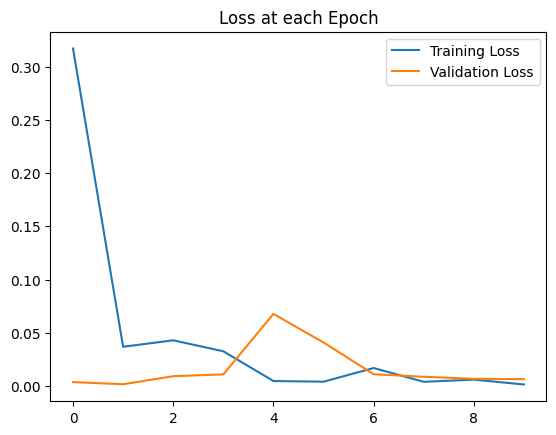

In [9]:
plt.plot(train_losses, label= 'Training Loss')
plt.plot(test_losses, label= 'Validation Loss')
plt.title('Loss at each Epoch')
plt.legend()

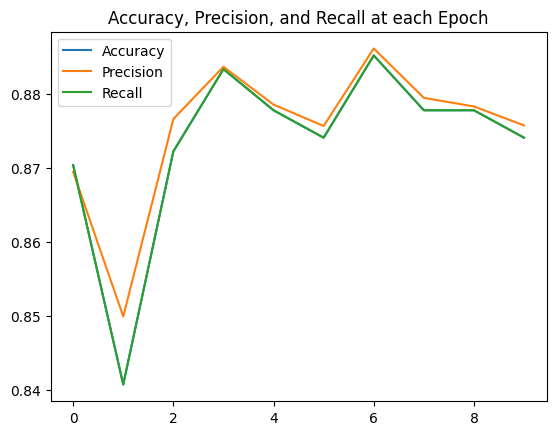

In [10]:
plt.plot(accuracy_graph, label= 'Accuracy')
plt.plot(precision_graph, label= 'Precision')
plt.plot(recall_graph, label='Recall')
plt.title('Accuracy, Precision, and Recall at each Epoch')
plt.legend()


In [7]:
if "model" in globals():
    del model.backbone_model
    del model
torch.cuda.empty_cache()

model = RealWasteModel("RealWasteEpoch/RealWaste_Epoch_6.pt")
model = model.cuda()
model.eval()

Using cache found in /home/azureuser/.cache/torch/hub/facebookresearch_dinov2_main
/home/azureuser/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/azureuser/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/azureuser/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


RealWasteModel(
  (fc1): Linear(in_features=1536, out_features=9, bias=True)
  (backbone_model): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1536, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-39): 40 x NestedTensorBlock(
        (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=1536, out_features=4608, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1536, out_features=1536, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
        (mlp): SwiGLUFFNFused(
          (w12): Linear(in_features=1536, out_features=8192, bias=True)
          (w3): Linear(in_features=4096, out_features=1536, bias=True)
        )
  

In [12]:
y_true_label = []
predictions = []
test_load_all = DataLoader(eval_ds, batch_size=10, shuffle=False)

with torch.no_grad():
    correct = 0
    for b, (X_test, y_test) in tqdm(enumerate(test_load_all)):
        y_val = model(X_test.cuda())
        predicted = torch.max(y_val.data, 1)[1]
        correct += (predicted == y_test.cuda()).sum()
        y_true_label.extend(y_test.cpu().detach().numpy())
        predictions.extend(predicted.cpu().detach().numpy())

print(f'Test Accuracy: {correct.item()/len(eval_df)*100:.2f}%')

0it [00:00, ?it/s]

Test Accuracy: 88.52%


['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


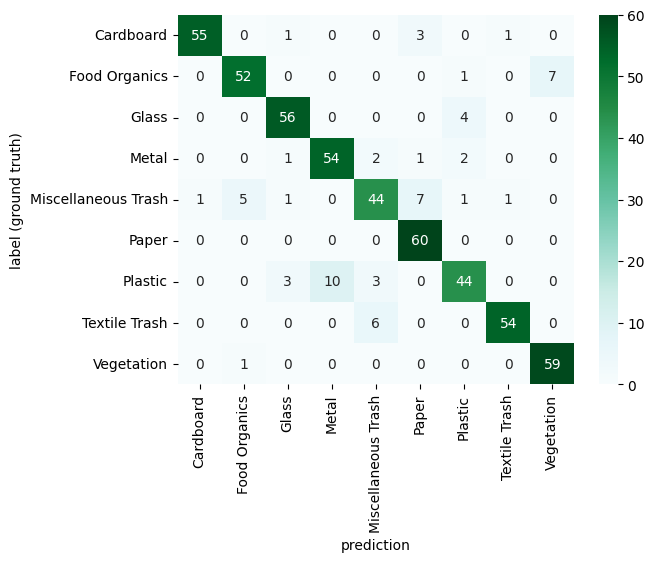

In [10]:
confusion_names = labels.copy()
print(confusion_names)
arr = confusion_matrix(y_true_label, predictions)
df_cm = pd.DataFrame(arr, confusion_names, confusion_names)
plt.figure()
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

In [ ]:
pred = labels.index('X')
lbl = labels.index('T')
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] == pred and y_test[i] == lbl:
        misses = np.append(misses,i).astype('int64')
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}'))
r = 24
row = iter(np.array_split(misses,len(misses)//r+1))
nextrow = next(row)
lbls = y_test.index_select(0,torch.tensor(nextrow)).numpy()
gues = predicted.index_select(0,torch.tensor(nextrow)).numpy()
print("Index:", nextrow)
print("Label:", lbls)
print("Class: ", *np.array([labels[i] for i in lbls]))
print()
print("Guess:", gues)
print("Class: ", *np.array([labels[i] for i in gues]))

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(24,24))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

